# Identifying Friendly Squirrels #

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.5"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.5"):
    print(FAIL, "Python version 3.12.5 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.26.4", 'matplotlib': "3.9.2",'sklearn': "1.5.1", 
                'pandas': "2.2.2",'xgboost': "2.1.1", 'shap': "0.45.1", 
                'plotly': "5.23.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.5

[ OK ] numpy version 1.26.4 is installed.
[ OK ] matplotlib version 3.9.2 is installed.
[ OK ] sklearn version 1.5.1 is installed.
[ OK ] pandas version 2.2.2 is installed.
[ OK ] xgboost version 2.1.1 is installed.
[ OK ] shap version 0.45.1 is installed.
[ OK ] plotly version 5.23.0 is installed.


In [2]:
import numpy as np 
import pandas as pd
import matplotlib 
from matplotlib import pylab as plt
import os

In [3]:
# Load dataset
df_original = pd.read_csv('/Users/songxiaoke/Desktop/1030project_squirrels/data/central_part_squirrels_(raw).csv')
df_original.head()

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894)


# Exploratory Data Analysis #

In [4]:
print(df_original.shape)

(3023, 31)


In [5]:
df_original.describe()

,X,Y,Date,Hectare Squirrel Number
count,3023.000000,3023.000000,3.023000e+03,3023.000000
mean,-73.967184,40.780853,1.011949e+07,4.123718
std,0.007726,0.010285,4.246671e+04,3.096492
min,-73.981159,40.764911,1.006202e+07,1.000000
25%,-73.973102,40.771676,1.008202e+07,2.000000
50%,-73.968594,40.778166,1.012202e+07,3.000000
75%,-73.960189,40.791219,1.014202e+07,6.000000
max,-73.949722,40.800119,1.020202e+07,23.000000


#### Check Missing Values for Original Datasets ####

In [6]:
# Check Missing valyes for Original Datasets
perc_missing_per_ftr = df_original.isnull().sum(axis = 0)/df_original.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df_original[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df_original.isnull().sum(axis = 1)!=0)/df_original.shape[0]
print('fraction of points with missing vlaues:', frac_missing)

fraction of missing values in features:
Age                                 0.040026
Primary Fur Color                   0.018194
Highlight Fur Color                 0.359246
Color notes                         0.939795
Location                            0.021171
Above Ground Sighter Measurement    0.037711
Specific Location                   0.842541
Other Activities                    0.855442
Other Interactions                  0.920609
dtype: float64
data types of the features with missing values:
Age                                 object
Primary Fur Color                   object
Highlight Fur Color                 object
Color notes                         object
Location                            object
Above Ground Sighter Measurement    object
Specific Location                   object
Other Activities                    object
Other Interactions                  object
dtype: object
fraction of points with missing vlaues: 0.9996692027786966


#### Drop Feratures Provide No Predictive Power ####

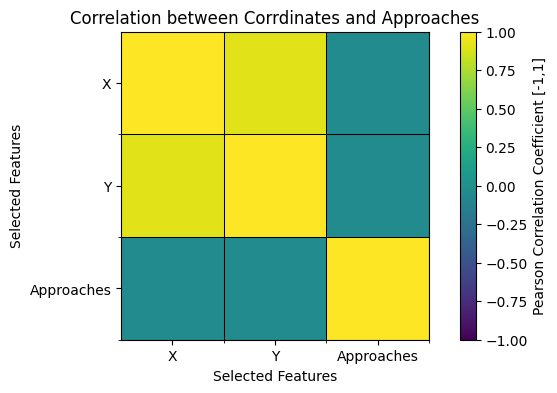

In [7]:
# Test Correlation Between Approaches and X, Y

selected = ['X', 'Y', 'Approaches']

corr_matrix = df_original[selected].corr()

plt.figure(figsize = (8,4))
plt.imshow(corr_matrix, vmin = -1, vmax = 1)
plt.colorbar(label = 'Pearson Correlation Coefficient [-1,1]')

ax = plt.gca()
ax.set_xticks(np.arange(len(corr_matrix.columns)) + 0.5, minor=True)
ax.set_yticks(np.arange(len(corr_matrix.columns)) + 0.5, minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.75)

plt.title('Correlation between Corrdinates and Approaches')
plt.xlabel('Selected Features')
plt.ylabel('Selected Features')
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)

# Save the plot to the specified path
# desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "correlation_plot.png")
# plt.savefig(fname=desktop_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Drop columns provide no predictive values
columns_to_drop = ['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Date', 
                   'Hectare Squirrel Number', 'Highlight Fur Color', 
                   'Combination of Primary and Highlight Color', 'Specific Location',
                   'Color notes', 'Lat/Long', 'Above Ground Sighter Measurement',
                  'Other Interactions','Other Activities']
df = df_original.drop(columns=columns_to_drop)
print(df.shape)
df.head()

(3023, 17)


,Shift,Age,Primary Fur Color,Location,Running,Chasing,Climbing,Eating,Foraging,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from
0,PM,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False
1,AM,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False
2,PM,NaN,Gray,Above Ground,False,True,False,False,False,False,False,False,False,False,False,False,False
3,PM,Adult,Gray,NaN,False,False,False,True,True,False,False,False,False,False,False,False,True
4,AM,Adult,Gray,Above Ground,False,False,False,False,True,False,False,False,False,False,False,False,False


In [9]:
df.describe()

,Shift,Age,Primary Fur Color,Location,Running,Chasing,Climbing,Eating,Foraging,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from
count,3023,2902,2968,2959,3023,3023,3023,3023,3023,3023,3023,3023,3023,3023,3023,3023,3023
unique,2,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,PM,Adult,Gray,Ground Plane,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,1676,2568,2473,2116,2293,2744,2365,2263,1588,2921,2973,3020,2868,2589,2845,1569,2345


In [10]:
# Identify data types for each columns
print(df.dtypes)

Shift                object
Age                  object
Primary Fur Color    object
Location             object
Running                bool
Chasing                bool
Climbing               bool
Eating                 bool
Foraging               bool
Kuks                   bool
Quaas                  bool
Moans                  bool
Tail flags             bool
Tail twitches          bool
Approaches             bool
Indifferent            bool
Runs from              bool
dtype: object


#### Re-Check Missing Values after Dropping Features with No Predictive Power ####

In [11]:
# Check Missing value
print('number of corresponding missing values:')
print(df.isnull().sum())

number of corresponding missing values:
Shift                  0
Age                  121
Primary Fur Color     55
Location              64
Running                0
Chasing                0
Climbing               0
Eating                 0
Foraging               0
Kuks                   0
Quaas                  0
Moans                  0
Tail flags             0
Tail twitches          0
Approaches             0
Indifferent            0
Runs from              0
dtype: int64


In [12]:
# Check Missing valyes for Original Datasets
perc_missing_per_ftr = df.isnull().sum(axis = 0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis = 1)!=0)/df.shape[0]
print('fraction of points with missing vlaues:', frac_missing)

fraction of missing values in features:
Age                  0.040026
Primary Fur Color    0.018194
Location             0.021171
dtype: float64
data types of the features with missing values:
Age                  object
Primary Fur Color    object
Location             object
dtype: object
fraction of points with missing vlaues: 0.06582864703936486


#### Replace nan with 'Unknown' for Categorical features ####

In [13]:
df['Age'] = df['Age'].replace('?', np.nan)
df['Age'] = df['Age'].fillna('Unknown') 
print(df['Age'].unique())

['Unknown' 'Adult' 'Juvenile']


In [14]:
df['Primary Fur Color'] = df['Primary Fur Color'].fillna('Unknown') 
print(df['Primary Fur Color'].unique())

['Unknown' 'Gray' 'Cinnamon' 'Black']


In [15]:
df['Location'] = df['Location'].fillna('Unknown') 
print(df['Location'].unique())

['Unknown' 'Above Ground' 'Ground Plane']


#### Balances of each class in the Target variable & Visualization ####

[False  True]
Approaches
False    2845
True      178
Name: count, dtype: int64


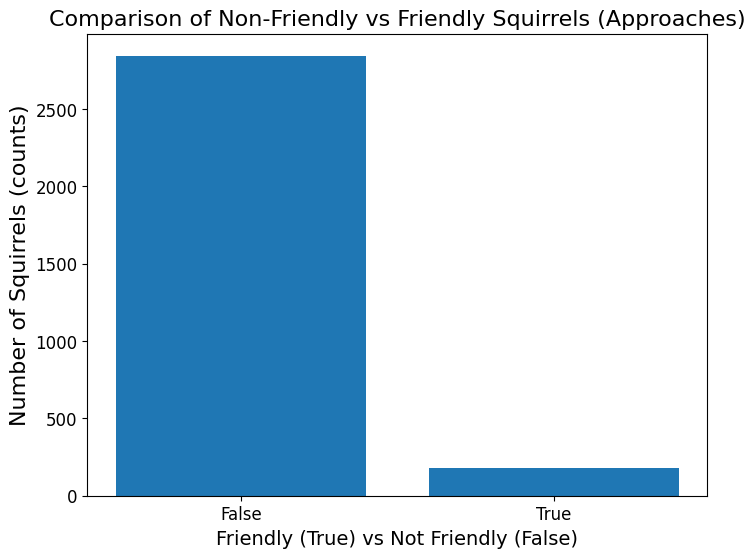

In [16]:
# Check distribution of target variable 'Approaches'
print(df['Approaches'].unique())
print(df['Approaches'].value_counts())

# A bar plot to show distribution
plt.figure(figsize = (8,6))
plt.bar(df['Approaches'].value_counts().index.astype(str), height = df_original['Approaches'].value_counts().values)
plt.title('Comparison of Non-Friendly vs Friendly Squirrels (Approaches)', fontsize=16)
plt.xlabel('Friendly (True) vs Not Friendly (False)', fontsize=14)
plt.ylabel('Number of Squirrels (counts)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "squirrel_approaches_distribution.png")
# plt.savefig(fname=desktop_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

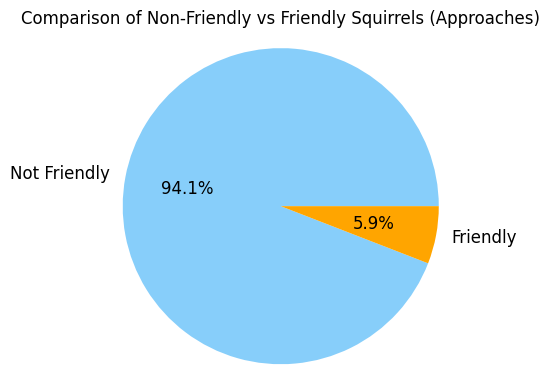

In [17]:
# Similar but Pie Plot
plt.figure(figsize=(5, 4))
plt.pie(df_original['Approaches'].value_counts(), labels=['Not Friendly', 'Friendly'], 
        autopct='%1.1f%%', textprops={'fontsize': 12}, colors = ['lightskyblue', 'orange'])
plt.title('Comparison of Non-Friendly vs Friendly Squirrels (Approaches)', fontsize=12)
plt.axis('equal')
plt.tight_layout()

# desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "squirrel_distribution_pie.png")
# plt.savefig(fname=desktop_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

#### Squirrels Distribution thoughout the Park ####

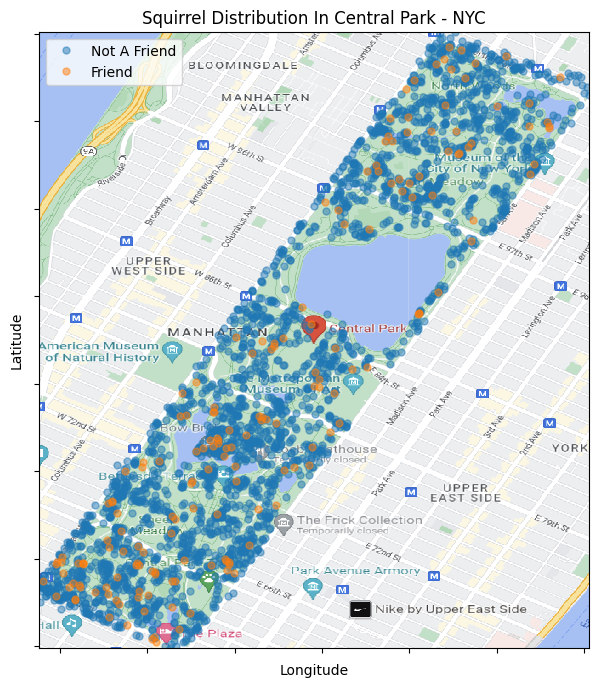

In [18]:
image_path = os.path.join(os.path.expanduser("~"), "Desktop", "1030project_squirrels", "figures", "central_park.png")

extent = (df_original['X'].min(), df_original['X'].max(), df_original['Y'].min(), df_original['Y'].max())
im = plt.imread(image_path)

plt.figure(figsize=(10, 8))
plt.imshow(im, interpolation='nearest', extent=extent)

sq_groups = df_original.groupby('Approaches')

for name, group in sq_groups:
    label = 'Friend' if name else 'Not A Friend'
    plt.plot(group['X'], group['Y'], marker='o', linestyle='', markersize=5, label=label, alpha=0.5)

plt.title('Squirrel Distribution In Central Park - NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper left')
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "squirrel_distribution_cp.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

#### More Visualizations Investigating different Features ####

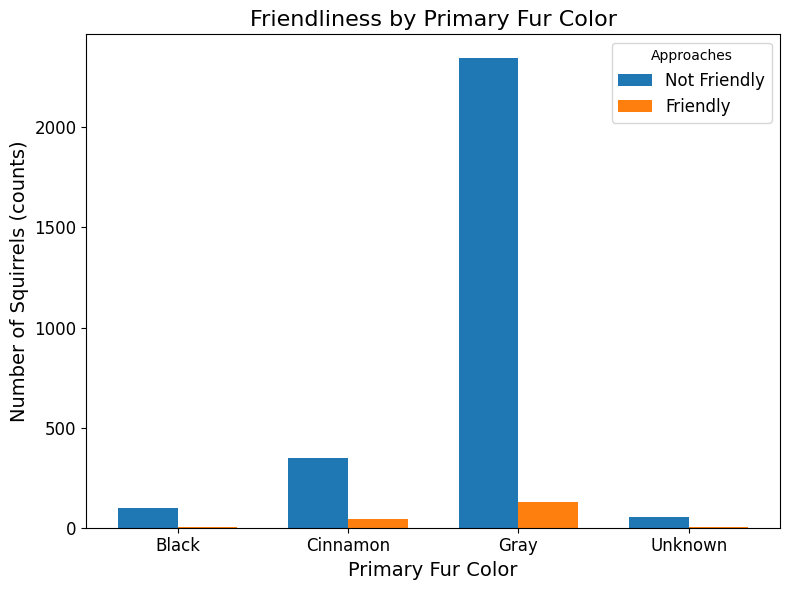

In [19]:
# Whether squirrels of different fur colors are more or less likely to approach humans
fur_counts = df.groupby('Primary Fur Color')['Approaches'].value_counts().unstack(fill_value=0)

# Create a bar plot
bar_width = 0.35
index = np.arange(len(fur_counts))
plt.figure(figsize=(8, 6))
plt.bar(index, fur_counts[False], bar_width, label='Not Friendly')
plt.bar(index + bar_width, fur_counts[True], bar_width, label='Friendly')
plt.title('Friendliness by Primary Fur Color', fontsize=16) 
plt.xlabel('Primary Fur Color', fontsize=14)  
plt.ylabel('Number of Squirrels (counts)', fontsize=14)  
plt.xticks(index + bar_width / 2, fur_counts.index, fontsize=12)
plt.yticks(fontsize=12) 
plt.legend(['Not Friendly', 'Friendly'], title="Approaches", fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_furcolor.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

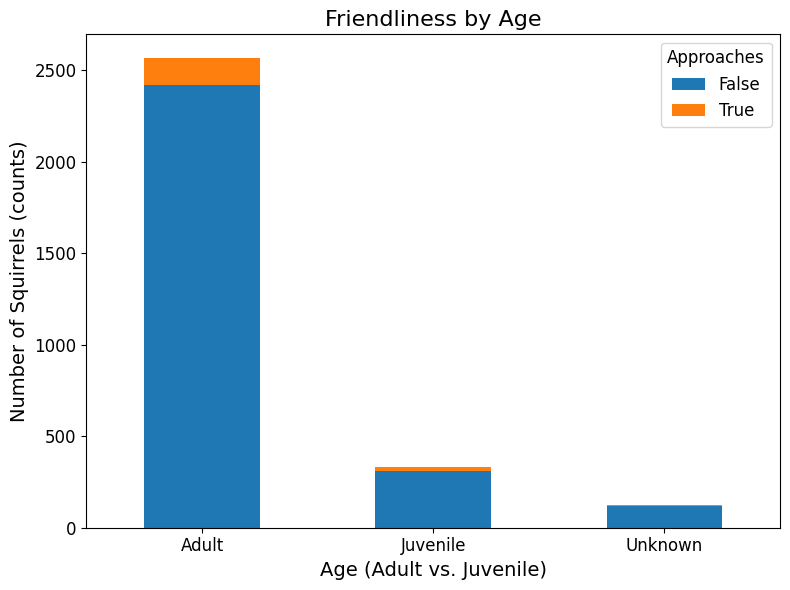

In [20]:
# Visulaize if age (adult vs. juvenile) affects how friendly squirrels are
age_counts = df.groupby('Age')['Approaches'].value_counts().unstack().dropna()

# Stacked bar plot
age_counts.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Friendliness by Age', fontsize=16)  
plt.xlabel('Age (Adult vs. Juvenile)', fontsize=14)  
plt.ylabel('Number of Squirrels (counts)', fontsize=14)
plt.xticks(rotation=0, fontsize=12) 
plt.yticks(fontsize=12)
plt.legend(title="Approaches", fontsize=12, title_fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_age.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

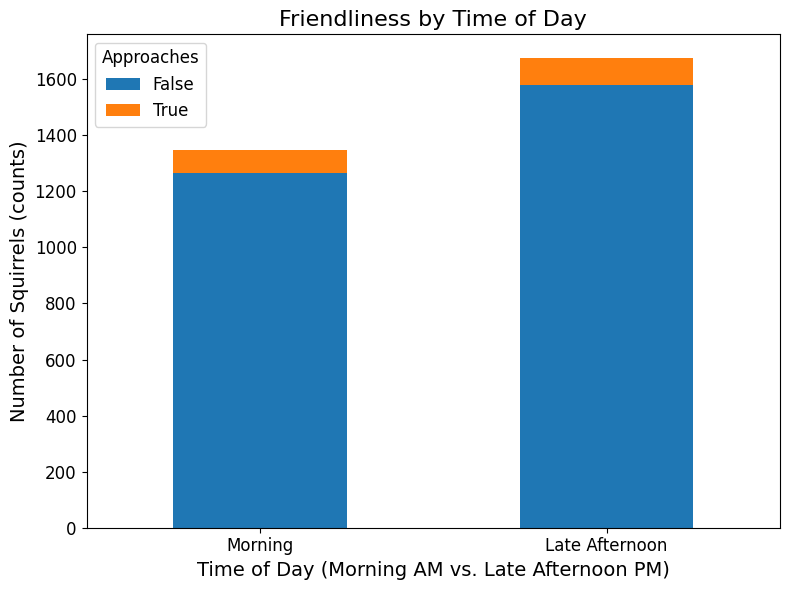

In [21]:
# if the time of day (shift: morning vs. late afternoon) influences squirrel behavior 
shift_approach = df.groupby('Shift')['Approaches'].value_counts().unstack()

# stacked bar plot
shift_approach.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Friendliness by Time of Day', fontsize=16)  
plt.xlabel('Time of Day (Morning AM vs. Late Afternoon PM)', fontsize=14)  
plt.ylabel('Number of Squirrels (counts)', fontsize=14)
plt.xticks([0, 1], ['Morning', 'Late Afternoon'], rotation = 0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Approaches", fontsize=12, title_fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_time_day.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

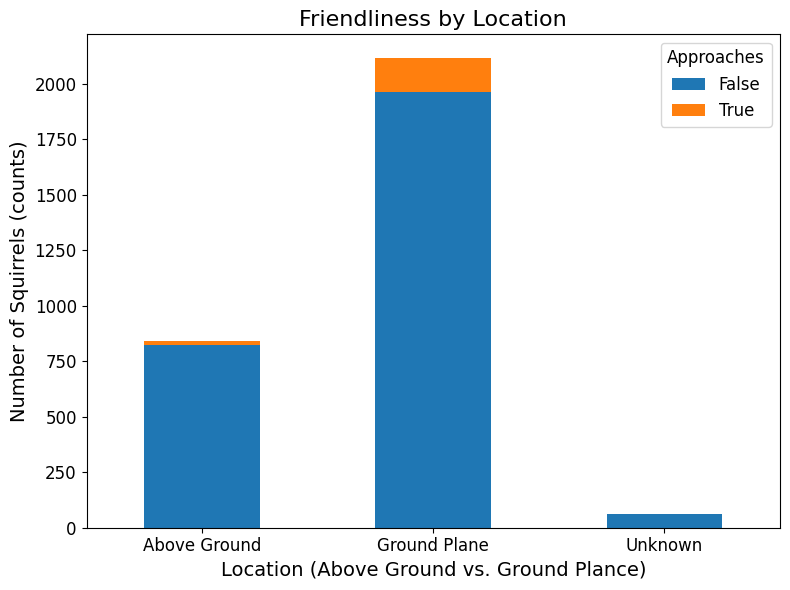

In [22]:
# if the location (above ground vs. ground plane) influences squirrel behavior 
shift_approach = df.groupby('Location')['Approaches'].value_counts().unstack()

# stacked bar plot
shift_approach.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Friendliness by Location', fontsize=16)  
plt.xlabel('Location (Above Ground vs. Ground Plance)', fontsize=14)  
plt.ylabel('Number of Squirrels (counts)', fontsize=14)
plt.xticks([0, 1, 2], ['Above Ground', 'Ground Plane', 'Unknown'], rotation = 0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Approaches", fontsize=12, title_fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_location.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

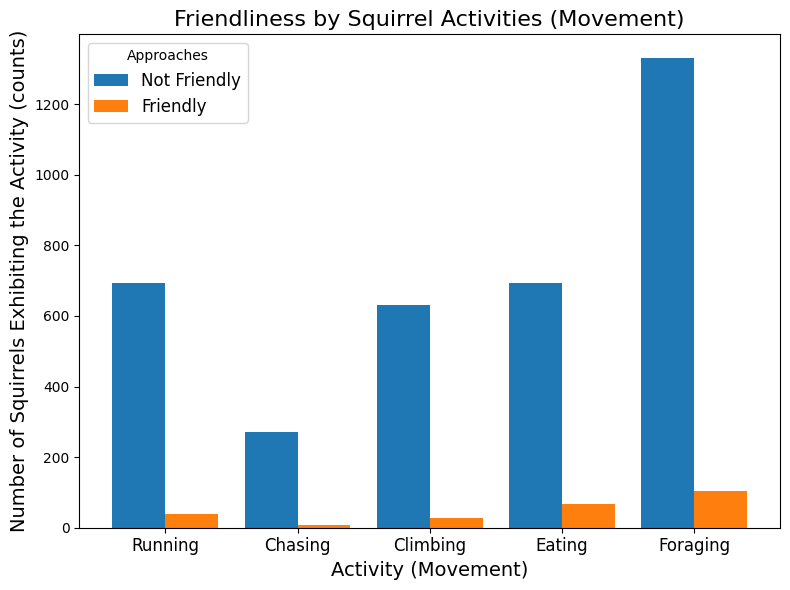

In [23]:
# Activities as a signal

# Group 1: Running, Chasing, Climbing, Eating, Foraging
activity_group_1 = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging']
activity_approach_counts_1 = df.groupby('Approaches')[activity_group_1].sum().T

# Plot the results in a bar plot for group 1
plt.figure(figsize=(8, 6))
activity_approach_counts_1.plot(kind='bar', ax=plt.gca(), width=0.8)  # Remove stacked=True
plt.title('Friendliness by Squirrel Activities (Movement)', fontsize=16)
plt.xlabel('Activity (Movement)', fontsize=14)
plt.ylabel('Number of Squirrels Exhibiting the Activity (counts)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(['Not Friendly', 'Friendly'], title="Approaches", fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_movement_activities.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

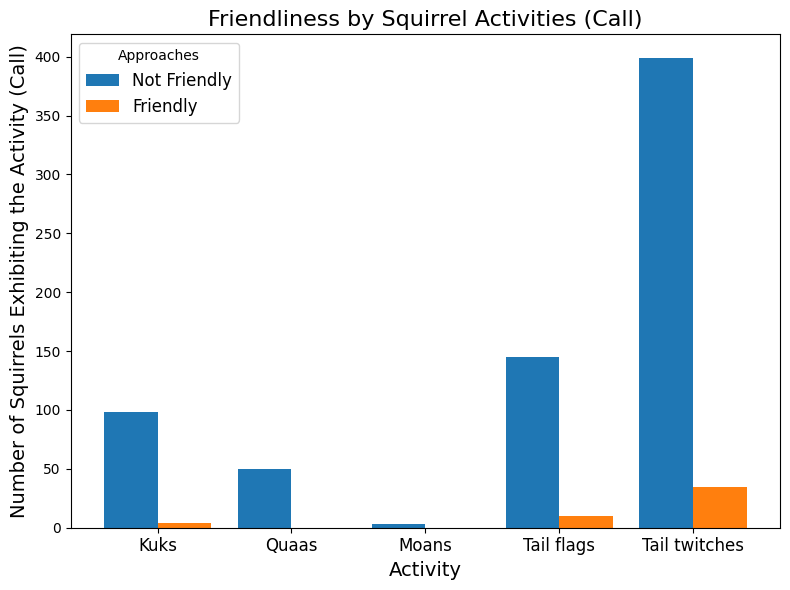

In [24]:
# Group 2: Kuks, Quaas, Moans, Tail flags, Tail twitches
activity_group_2 = ['Kuks', 'Quaas', 'Moans', 'Tail flags', 'Tail twitches']
activity_approach_counts_2 = df.groupby('Approaches')[activity_group_2].sum().T

# Plot the results in a stacked bar plot for group 2
plt.figure(figsize=(8, 6))
activity_approach_counts_2.plot(kind='bar', ax=plt.gca(), width = 0.8)
plt.title('Friendliness by Squirrel Activities (Call)', fontsize=16)
plt.xlabel('Activity', fontsize=14)
plt.ylabel('Number of Squirrels Exhibiting the Activity (Call)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(['Not Friendly', 'Friendly'], title="Approaches", fontsize=12)
plt.tight_layout()

# save_path = os.path.join(os.path.expanduser("~"), "Desktop", "Comparison_call_activities.png")
# plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

# Models #

In [25]:
y = df['Approaches'] # targeted variable
X = df.loc[:, df.columns != 'Approaches'] # feature matrix

#### Baseline Accuracy Score ####

In [26]:
Unfri, Fri = df['Approaches'].value_counts()
baseline_accuracy = Unfri/(Unfri+Fri)
print('Baseline accuracy score for the entrie dataset is', baseline_accuracy)

Baseline accuracy score for the entrie dataset is 0.9411180946080053


In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

#### Store Preprocessing Encoders in Preprocessor ####

In [28]:
print(df.dtypes)

Shift                object
Age                  object
Primary Fur Color    object
Location             object
Running                bool
Chasing                bool
Climbing               bool
Eating                 bool
Foraging               bool
Kuks                   bool
Quaas                  bool
Moans                  bool
Tail flags             bool
Tail twitches          bool
Approaches             bool
Indifferent            bool
Runs from              bool
dtype: object


In [29]:
# Define different-types features
categorical_ftrs = ['Shift', 'Age', 'Primary Fur Color', 'Location']
boolean_ftrs = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 
                'Kuks', 'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 
                'Indifferent', 'Runs from']

# Apply preprocessing and Combine all transformers
preprocessor = ColumnTransformer(
    transformers = [
        ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'), categorical_ftrs),
        ('boolean', StandardScaler(), boolean_ftrs)])

## Logistic Regression ##

In [30]:
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['elasticnet'],
    'logisticregression__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}  # so that 0 indicates L2, 1 indicated L1

nr_states = 5
lr_test_scores = []
lr_final_models = []

# Hyperparameter tuning with folds
for i in range(nr_states):
    # First split to separate out the test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42*i)
    # splitter for other
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42*i) # Imbalanced, stratify

    # logistic regression
    lr = LogisticRegression(solver = 'saga', max_iter = 10000, random_state = 42*i)

    pipe = make_pipeline(preprocessor, lr)

    # GridSearchCV
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = 'accuracy', cv = kf, return_train_score = True, n_jobs = -1)

    # Fit the model on other and loops through the 4 different validation sets
    grid.fit(X_other, y_other)

    # Compare number of features before and after preprocessed
    if i == 0:  # Only print once
        best_pipe = grid.best_estimator_
        X_other_prep = best_pipe.named_steps['columntransformer'].transform(X_other)

        # Save preprocessed data
        # preprocessed_df = pd.DataFrame(
        #     X_other_prep, 
        #     columns = best_pipe.named_steps['columntransformer'].get_feature_names_out())
        # preprocessed_df['target'] = y_other.reset_index(drop = True)
        # desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
        # csv_path = os.path.join(desktop_path, "preprocessed_data.csv")
        # preprocessed_df.to_csv(csv_path, index = False)
        
        print(f'Number of features before preprocessed: {X_other.shape[1]}')
        print(f'Number of features after preprocessing: {X_other_prep.shape[1]}')

    # Save results into a data frame
    results_lr = pd.DataFrame(grid.cv_results_)
    # print(results_lr)

    print('\nBest model parameters:', grid.best_params_)
    print('validation score:', grid.best_score_)
    # save the model 
    lr_final_models.append(grid)

    # calculate and save the test score
    y_test_pred = lr_final_models[-1].predict(X_test)
    test_score = accuracy_score(y_test, y_test_pred)
    lr_test_scores.append(test_score)
    print('test score:', test_score)

Number of features before preprocessed: 16
Number of features after preprocessing: 24

Best model parameters: {'logisticregression__C': 0.01, 'logisticregression__l1_ratio': 0, 'logisticregression__penalty': 'elasticnet'}
validation score: 0.9433419079415466
test score: 0.9322314049586777

Best model parameters: {'logisticregression__C': 1, 'logisticregression__l1_ratio': 1, 'logisticregression__penalty': 'elasticnet'}
validation score: 0.9396194789557222
test score: 0.9487603305785124

Best model parameters: {'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0, 'logisticregression__penalty': 'elasticnet'}
validation score: 0.9412737398062503
test score: 0.9454545454545454

Best model parameters: {'logisticregression__C': 0.01, 'logisticregression__l1_ratio': 0, 'logisticregression__penalty': 'elasticnet'}
validation score: 0.9404466093809862
test score: 0.943801652892562

Best model parameters: {'logisticregression__C': 1, 'logisticregression__l1_ratio': 0.25, 'logisticreg

In [31]:
print(f'Test Accuracy Mean: {np.mean(lr_test_scores)}')
print(f'Test accuracy std: {np.std(lr_test_scores)}')

Test Accuracy Mean: 0.9421487603305785
Test accuracy std: 0.005629549211876476


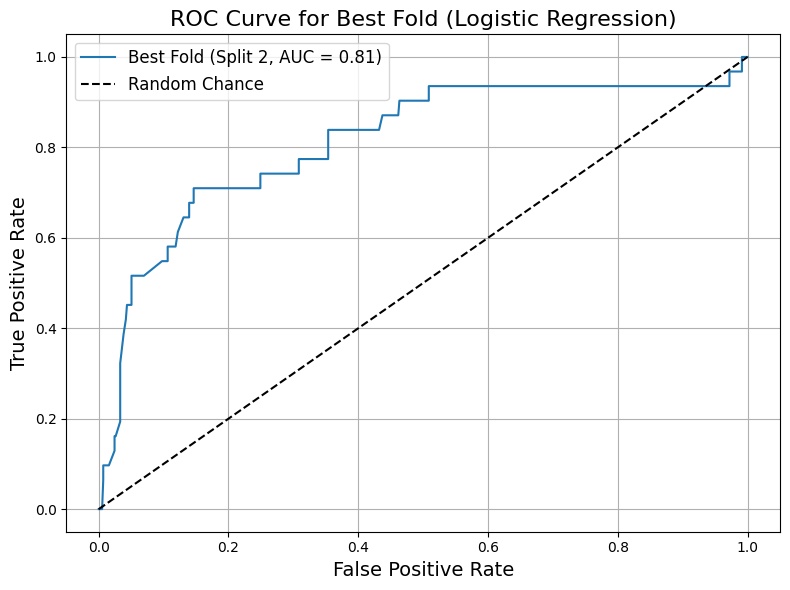

Best fold test score: 0.9487603305785124
Best fold AUC score: 0.8117061930987975


In [35]:
# Draw ROC curve with best prediction fold (based on test score)
best_fold_index = max(range(len(lr_test_scores)), key=lambda i: lr_test_scores[i])
best_model = lr_final_models[best_fold_index].best_estimator_

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=42 * best_fold_index)

preprocessor_fitted = best_model.named_steps['columntransformer']
X_test_prep = preprocessor_fitted.transform(X_test)

y_test_prob = best_model.named_steps['logisticregression'].predict_proba(X_test_prep)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
best_auc_score = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Best Fold (Split {best_fold_index + 1}, AUC = {best_auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Best Fold (Logistic Regression)', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

print(f"Best fold test score: {lr_test_scores[best_fold_index]}")
print(f"Best fold AUC score: {best_auc_score}")

## Random Forest ##

In [36]:
param_grid = {
    'randomforestclassifier__max_depth': [None, 1, 3, 10],
    'randomforestclassifier__max_features': [0.01, 0.03, 0.05, 0.1]}
nr_states = 5
rf_test_scores = []
rf_final_models = []

for i in range(nr_states):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42*i)
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42*i)

    rf = RandomForestClassifier(random_state = 42*i)

    pipe = make_pipeline(preprocessor, rf)

    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = 'accuracy', cv = kf, return_train_score = True, n_jobs = -1)

    grid.fit(X_other, y_other)

    results_rf = pd.DataFrame(grid.cv_results_)
    # print(results_rf)

    print('\nBest model parameters:', grid.best_params_)
    print('validation score:', grid.best_score_)

    rf_final_models.append(grid)

    y_test_pred = rf_final_models[-1].predict(X_test)
    test_score = accuracy_score(y_test, y_test_pred)
    rf_test_scores.append(test_score)
    print('test score:', test_score)


Best model parameters: {'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.01}
validation score: 0.9433419079415466
test score: 0.9322314049586777

Best model parameters: {'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.01}
validation score: 0.9392062558152263
test score: 0.9487603305785124

Best model parameters: {'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.01}
validation score: 0.9404466093809862
test score: 0.943801652892562

Best model parameters: {'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.01}
validation score: 0.9404466093809862
test score: 0.943801652892562

Best model parameters: {'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.01}
validation score: 0.9412744239505226
test score: 0.9404958677685951


In [38]:
print(f'Test Accuracy Mean: {np.mean(rf_test_scores)}')
print(f'Test accuracy std: {np.std(rf_test_scores)}')

Test Accuracy Mean: 0.9418181818181818
Test accuracy std: 0.005472048051982414


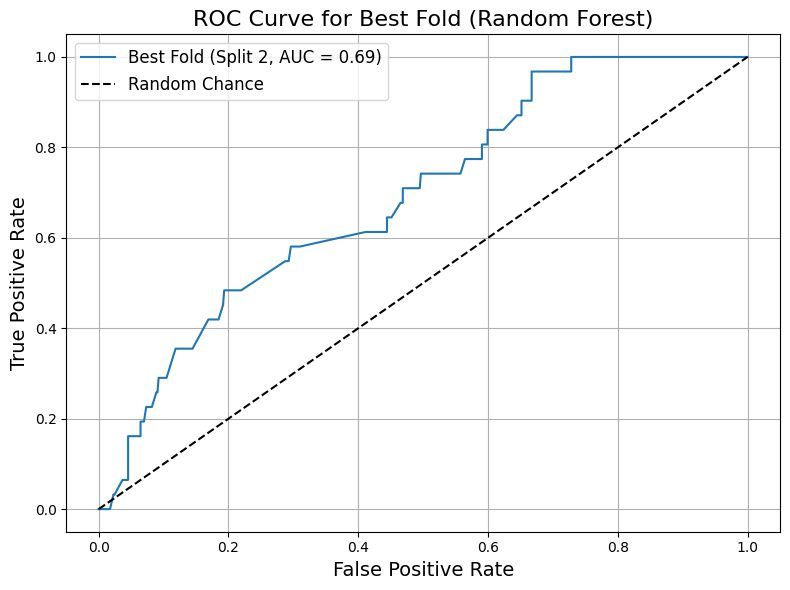

Best fold test score: 0.9487603305785124
Best fold AUC score: 0.6921153197707093


In [42]:
# Draw ROC curve with best prediction fold (based on test score for Random Forest)
best_fold_index = max(range(len(rf_test_scores)), key=lambda i: rf_test_scores[i])
best_model = rf_final_models[best_fold_index].best_estimator_

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=42 * best_fold_index)

preprocessor_fitted = best_model.named_steps['columntransformer']
X_test_prep = preprocessor_fitted.transform(X_test)

y_test_prob = best_model.named_steps['randomforestclassifier'].predict_proba(X_test_prep)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
best_auc_score = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Best Fold (Split {best_fold_index + 1}, AUC = {best_auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Best Fold (Random Forest)', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

print(f"Best fold test score: {rf_test_scores[best_fold_index]}")
print(f"Best fold AUC score: {best_auc_score}")

## SVC ##

In [43]:
param_grid = {
    'svc__gamma': [1e-5, 1e-3, 1e-1, 1e1],
    'svc__C': [1e-2, 1e-1, 1e0, 1e1]}
nr_states = 5
svc_test_scores = []
svc_final_models = []

for i in range(nr_states):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42*i)
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42*i)

    svc = SVC(probability = True, random_state = 42*i)

    pipe = make_pipeline(preprocessor, svc)

    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = 'accuracy', cv = kf, return_train_score = True, n_jobs = -1)

    grid.fit(X_other, y_other)

    results_svc = pd.DataFrame(grid.cv_results_)
    # print(results_svc)

    print('\nBest model parameters:', grid.best_params_)
    print('validation score:', grid.best_score_)

    svc_final_models.append(grid)

    y_test_pred = svc_final_models[-1].predict(X_test)
    test_score = accuracy_score(y_test, y_test_pred)
    svc_test_scores.append(test_score)
    print('test score:', test_score)


Best model parameters: {'svc__C': 0.01, 'svc__gamma': 1e-05}
validation score: 0.9433419079415466
test score: 0.9322314049586777

Best model parameters: {'svc__C': 0.01, 'svc__gamma': 1e-05}
validation score: 0.9392062558152263
test score: 0.9487603305785124

Best model parameters: {'svc__C': 0.01, 'svc__gamma': 1e-05}
validation score: 0.9404466093809862
test score: 0.943801652892562

Best model parameters: {'svc__C': 0.01, 'svc__gamma': 1e-05}
validation score: 0.9404466093809862
test score: 0.943801652892562

Best model parameters: {'svc__C': 0.01, 'svc__gamma': 1e-05}
validation score: 0.9412744239505226
test score: 0.9404958677685951


In [44]:
print(f'Test Accuracy Mean: {np.mean(svc_test_scores)}')
print(f'Test accuracy std: {np.std(svc_test_scores)}')

Test Accuracy Mean: 0.9418181818181818
Test accuracy std: 0.005472048051982414


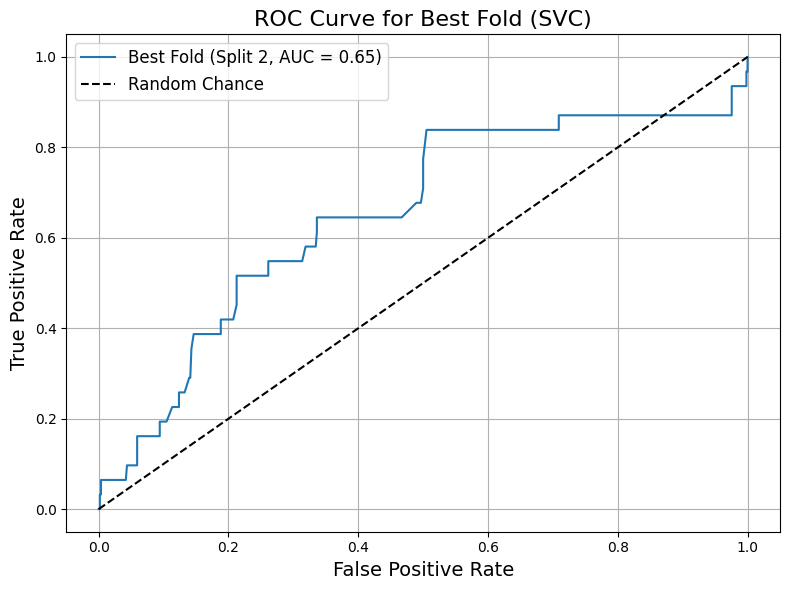

Best fold test score: 0.9487603305785124
Best fold AUC score: 0.652579521186917


In [46]:
# Draw ROC curve with best prediction fold (based on test score for SVC)
best_fold_index = max(range(len(svc_test_scores)), key=lambda i: svc_test_scores[i])
best_model = svc_final_models[best_fold_index].best_estimator_

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=42 * best_fold_index)

preprocessor_fitted = best_model.named_steps['columntransformer']
X_test_prep = preprocessor_fitted.transform(X_test)

y_test_prob = best_model.named_steps['svc'].predict_proba(X_test_prep)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
best_auc_score = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Best Fold (Split {best_fold_index + 1}, AUC = {best_auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Best Fold (SVC)', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# Print metrics for the best fold
print(f"Best fold test score: {svc_test_scores[best_fold_index]}")
print(f"Best fold AUC score: {best_auc_score}")

## KNN ##

In [47]:
param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 10, 30, 50]}
nr_states = 5
knn_test_scores = []
knn_final_models = []

for i in range(nr_states):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42*i)
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42*i)

    knn = KNeighborsClassifier()

    pipe = make_pipeline(preprocessor, knn)

    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = 'accuracy', cv = kf, return_train_score = True, n_jobs = -1)

    grid.fit(X_other, y_other)

    results_knn = pd.DataFrame(grid.cv_results_)
    # print(results_knn)

    print('\nBest model parameters:', grid.best_params_)
    print('validation score:', grid.best_score_)

    knn_final_models.append(grid)

    y_test_pred = knn_final_models[-1].predict(X_test)
    test_score = accuracy_score(y_test, y_test_pred)
    knn_test_scores.append(test_score)
    print('test score:', test_score)


Best model parameters: {'kneighborsclassifier__n_neighbors': 30}
validation score: 0.9433419079415466
test score: 0.9322314049586777

Best model parameters: {'kneighborsclassifier__n_neighbors': 30}
validation score: 0.9392062558152263
test score: 0.9487603305785124

Best model parameters: {'kneighborsclassifier__n_neighbors': 30}
validation score: 0.9404466093809862
test score: 0.943801652892562

Best model parameters: {'kneighborsclassifier__n_neighbors': 30}
validation score: 0.9404466093809862
test score: 0.943801652892562

Best model parameters: {'kneighborsclassifier__n_neighbors': 30}
validation score: 0.9412744239505226
test score: 0.9404958677685951


In [48]:
print(f'Test Accuracy Mean: {np.mean(knn_test_scores)}')
print(f'Test accuracy std: {np.std(knn_test_scores)}')

Test Accuracy Mean: 0.9418181818181818
Test accuracy std: 0.005472048051982414


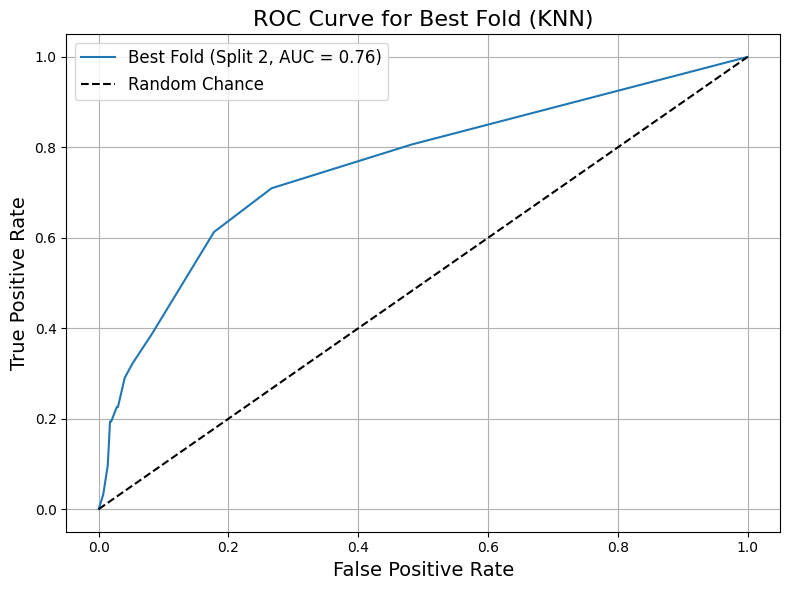

Best fold test score: 0.9487603305785124
Best fold AUC score: 0.7583455097223784


In [49]:
# Draw ROC curve with best prediction fold (based on test score for KNN)
best_fold_index = max(range(len(knn_test_scores)), key=lambda i: knn_test_scores[i])
best_model = knn_final_models[best_fold_index].best_estimator_

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=42 * best_fold_index)

preprocessor_fitted = best_model.named_steps['columntransformer']
X_test_prep = preprocessor_fitted.transform(X_test)

y_test_prob = best_model.named_steps['kneighborsclassifier'].predict_proba(X_test_prep)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
best_auc_score = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Best Fold (Split {best_fold_index + 1}, AUC = {best_auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Best Fold (KNN)', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

print(f"Best fold test score: {knn_test_scores[best_fold_index]}")
print(f"Best fold AUC score: {best_auc_score}")

## XGBoost ##

In [50]:
param_grid = {
    'learning_rate': [0.01, 0.03],
    'n_estimators': [500],
    'seed': [0],
    'reg_alpha': [0, 0.1, 0.5, 1, 2, 5],
    #'reg_lambda': [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e3],
    'max_depth': [1, 2, 3, 5, 10],
    'colsample_bytree': [0.9],
    'subsample': [0.66]}
nr_states = 5
xgb_test_scores = []
xgb_final_models = []

for i in range(nr_states):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=42 * i)
    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42 * i)

    X_other_prep = preprocessor.fit_transform(X_other)
    X_test_prep = preprocessor.transform(X_test)

    xgb = xgboost.XGBClassifier(seed=42 * i, eval_metric='logloss')

    grid = GridSearchCV(
        xgb,
        param_grid=param_grid,
        scoring='accuracy',
        cv=kf,
        return_train_score=True,
        n_jobs=-1
    )

    grid.fit(
        X_other_prep,
        y_other,
        eval_set=[(X_other_prep, y_other)],
        verbose=False
    )

    results_xgb = pd.DataFrame(grid.cv_results_)

    print('\nBest model parameters:', grid.best_params_)
    print('Validation score:', grid.best_score_)

    xgb_final_models.append(grid)

    y_test_pred = grid.best_estimator_.predict(X_test_prep)
    test_score = accuracy_score(y_test, y_test_pred)
    xgb_test_scores.append(test_score)
    print('Test score:', test_score)

    y_test_pred_proba = grid.best_estimator_.predict_proba(X_test_prep)[:, 1]


Best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500, 'reg_alpha': 0, 'seed': 0, 'subsample': 0.66}
Validation score: 0.9433419079415466
Test score: 0.9322314049586777

Best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 2, 'seed': 0, 'subsample': 0.66}
Validation score: 0.9396201630999945
Test score: 0.9487603305785124

Best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 1, 'n_estimators': 500, 'reg_alpha': 0.1, 'seed': 0, 'subsample': 0.66}
Validation score: 0.9408605166657544
Test score: 0.9454545454545454

Best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 0.5, 'seed': 0, 'subsample': 0.66}
Validation score: 0.9404472935252586
Test score: 0.943801652892562

Best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 1, 'n_estimator

In [51]:
print(f'Test Accuracy Mean: {np.mean(xgb_test_scores)}')
print(f'Test accuracy std: {np.std(xgb_test_scores)}')

Test Accuracy Mean: 0.9421487603305785
Test accuracy std: 0.005629549211876476


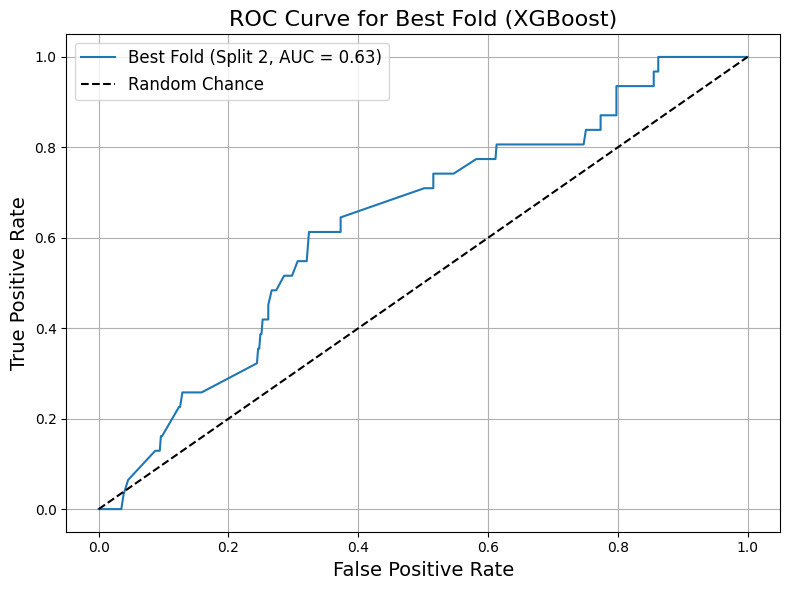

Best fold test score: 0.9487603305785124
Best fold AUC score: 0.6345397324940991


In [54]:
# Identify the best fold based on test score
best_fold_index = max(range(nr_states), key=lambda i: xgb_test_scores[i])
best_model = xgb_final_models[best_fold_index].best_estimator_

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=42 * best_fold_index)
X_test_prep = preprocessor.transform(X_test)
y_test_prob = best_model.predict_proba(X_test_prep)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
best_auc_score = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Best Fold (Split {best_fold_index + 1}, AUC = {best_auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Best Fold (XGBoost)', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

print(f"Best fold test score: {xgb_test_scores[best_fold_index]}")
print(f"Best fold AUC score: {best_auc_score}")

# Model Test Score Difference #

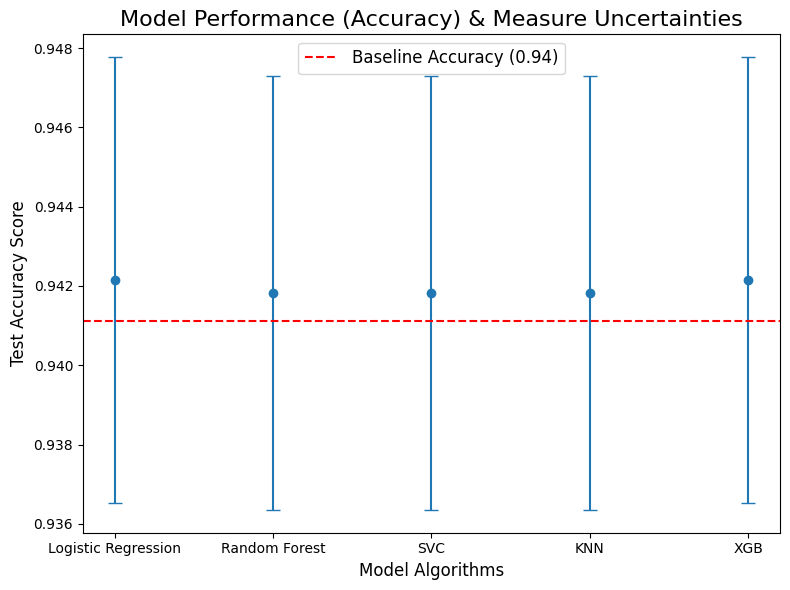

In [81]:
# Comparison based on accuracy
acc_means = [np.mean(lr_test_scores), np.mean(rf_test_scores), np.mean(svc_test_scores), np.mean(knn_test_scores), np.mean(xgb_test_scores)]
acc_stds = [np.std(lr_test_scores), np.std(rf_test_scores), np.std(svc_test_scores), np.std(knn_test_scores), np.std(xgb_test_scores)]
plt.figure(figsize = (8, 6))
plt.errorbar(['Logistic Regression', 'Random Forest', 'SVC', 'KNN', 'XGB'], acc_means, yerr = acc_stds, capsize = 5, fmt = 'o')
plt.axhline(y = baseline_accuracy, color = 'r', linestyle = '--', label = f'Baseline Accuracy ({baseline_accuracy:.2f})')
plt.title('Model Performance (Accuracy) & Measure Uncertainties', fontsize=16)
plt.xlabel('Model Algorithms', fontsize=12)
plt.ylabel('Test Accuracy Score', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

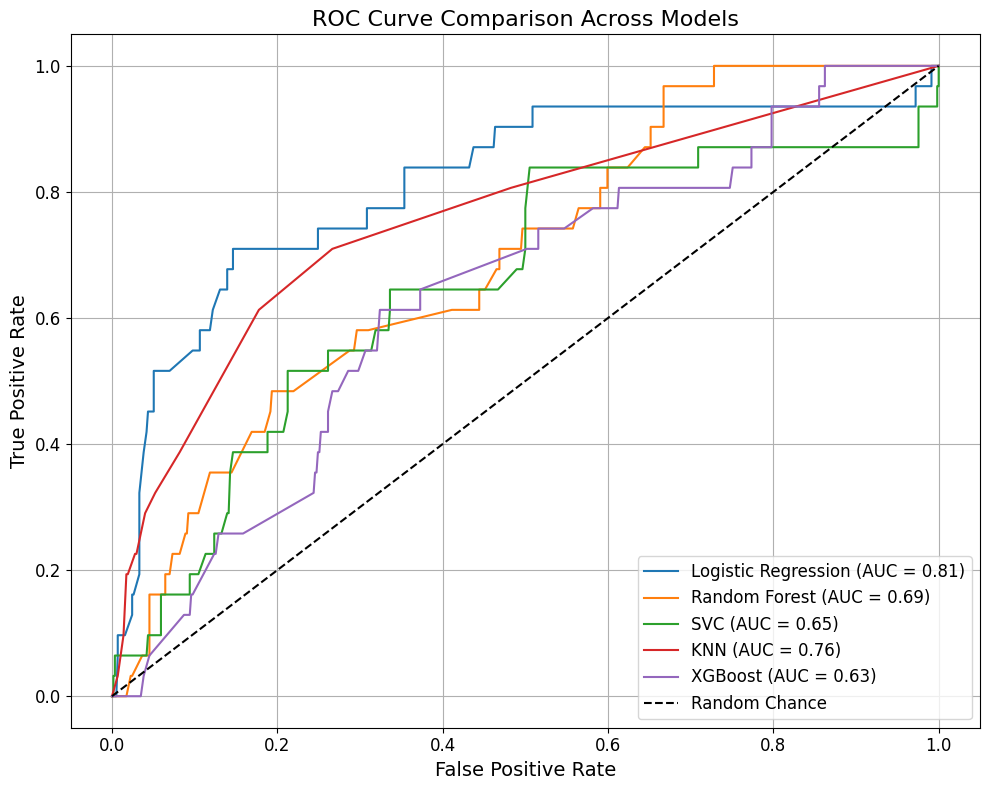

In [80]:
# Comparison based on ROC curve (best test score each model)
plt.figure(figsize=(10, 8))

models = [
    ('Logistic Regression', lr_final_models, lr_test_scores),
    ('Random Forest', rf_final_models, rf_test_scores),
    ('SVC', svc_final_models, svc_test_scores),
    ('KNN', knn_final_models, knn_test_scores),
    ('XGBoost', xgb_final_models, xgb_test_scores)
]

for model_name, final_models, test_scores in models:
    best_fold_index = max(range(len(test_scores)), key=lambda i: test_scores[i])
    best_model = final_models[best_fold_index].best_estimator_

    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=42 * best_fold_index)

    if model_name != 'XGBoost':  # XGBoost not in the pipeline
        preprocessor_fitted = best_model.named_steps['columntransformer']
        X_test_prep = preprocessor_fitted.transform(X_test)

        classifier_name = list(best_model.named_steps.keys())[-1]
        y_test_prob = best_model.named_steps[classifier_name].predict_proba(X_test_prep)[:, 1]
    else: 
        X_test_prep = preprocessor.transform(X_test)
        y_test_prob = best_model.predict_proba(X_test_prep)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    auc_score = roc_auc_score(y_test, y_test_prob)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison Across Models', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

Logistic Regression: Mean AUC = 0.8159716330074552, Std AUC = 0.027107959049165267

Random Forest: Mean AUC = 0.7504303041148702, Std AUC = 0.03164963358871329

SVC: Mean AUC = 0.6960878420188324, Std AUC = 0.031159321410436414

KNN: Mean AUC = 0.7660575095679242, Std AUC = 0.04668865390011516

XGBoost: Mean AUC = 0.677582386189496, Std AUC = 0.09126240799796602



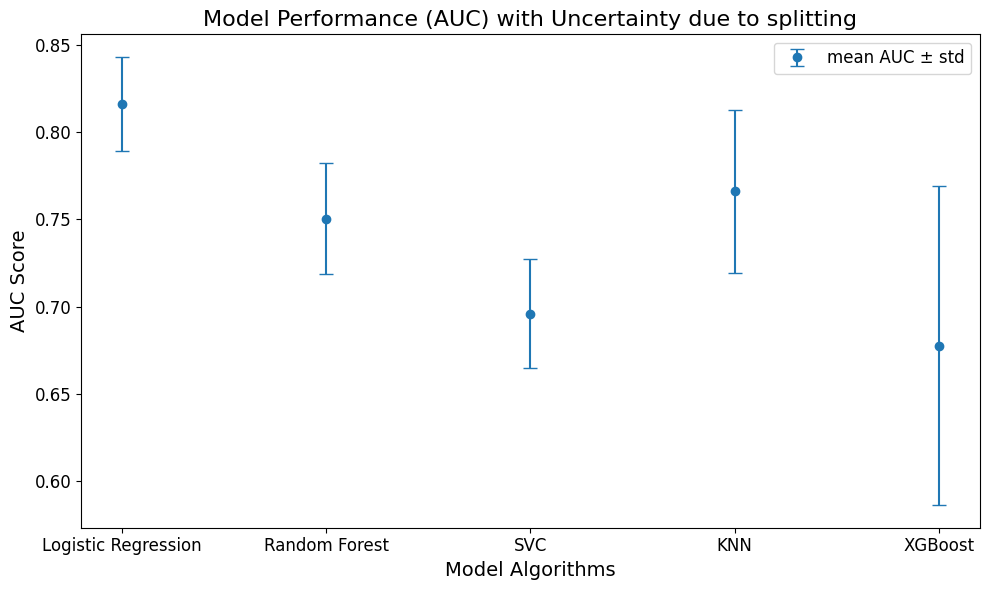

In [88]:
# Comparison based on AUC value under ROC curve
models = [
    ('Logistic Regression', lr_final_models),
    ('Random Forest', rf_final_models),
    ('SVC', svc_final_models),
    ('KNN', knn_final_models),
    ('XGBoost', xgb_final_models)
]

auc_results = {}

for model_name, final_models in models:
    auc_values = []
    
    for i, grid in enumerate(final_models):
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=42 * i)

        if model_name != 'XGBoost':  # XGBoost not in pipeline
            best_model = grid.best_estimator_
            preprocessor_fitted = best_model.named_steps['columntransformer']
            X_test_prep = preprocessor_fitted.transform(X_test)
            classifier_name = list(best_model.named_steps.keys())[-1]
            y_test_prob = best_model.named_steps[classifier_name].predict_proba(X_test_prep)[:, 1]
        else: 
            best_model = grid.best_estimator_
            X_test_prep = preprocessor.transform(X_test)
            y_test_prob = best_model.predict_proba(X_test_prep)[:, 1]

        auc = roc_auc_score(y_test, y_test_prob)
        auc_values.append(auc)

    auc_results[model_name] = auc_values

model_names = []
auc_means = []
auc_stds = []

for model_name, auc_values in auc_results.items():
    mean_auc = np.mean(auc_values)
    std_auc = np.std(auc_values)
    model_names.append(model_name)
    auc_means.append(mean_auc)
    auc_stds.append(std_auc)
    print(f"{model_name}: Mean AUC = {mean_auc}, Std AUC = {std_auc}\n")

plt.figure(figsize=(10, 6))
plt.errorbar(model_names, auc_means, yerr = auc_stds, fmt = 'o', capsize = 5, label = 'mean AUC ± std')
plt.title('Model Performance (AUC) with Uncertainty due to splitting', fontsize=16)
plt.xlabel('Model Algorithms', fontsize=14)
plt.ylabel('AUC Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()